In [156]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm

from pymc3 import *

print(f"Running on PyMC3 v{pm.__version__}")

import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import math
from scipy.stats.mstats import gmean
from scipy.stats import gamma,poisson,linregress,beta,norm
from scipy import optimize
import time
import random
import pickle as pkl
from cratrcountr import *

Running on PyMC3 v3.11.2


In [4]:
%config InlineBackend.figure_format = 'retina'
az.style.use("arviz-darkgrid")

In [172]:
def get_synth(synth_area=100000,synth_age=2.0,d_min=0.001,d_max=1000.0,inc=0.001):
    count_adj=ncf(synth_age)/ncf(1)
    rand_array=np.arange(np.log10(d_min),np.log10(d_max),inc)
    max_count=int(round(10*inc/0.0001*synth_area/100000))
    prob_array=(npf_new(10**(rand_array-inc/2))-npf_new(10**(rand_array+inc/2)))*synth_area*count_adj
    synth_i = np.array([np.random.choice(np.arange(0,max_count),p=poisson.pmf(np.arange(0,max_count),prob))\
                            for prob in prob_array])
    synth_ds=10**np.repeat(rand_array,synth_i)
    return synth_ds

In [175]:
ncf(2.3)/ncf(1)

2.30055628391291

In [174]:
get_synth(synth_area=100000,synth_age=2.0,d_min=0.1,d_max=10.0)

ValueError: probabilities do not sum to 1

/var/folders/h1/c6fm27mx0_s2s16rjtynr_hw0000gn/T/ipykernel_87541/2042995708.py:29: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(tune=2000)  # draw posterior samples using NUTS sampling
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [x, Intercept]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 10 seconds.
There were 522 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8980089084856757, but should be close to 0.8. Try to increase the number of tuning steps.
There were 523 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8862044912734967, but should be close to 0.8. Try to increase the number of tuning steps.
There were 587 divergences after tuning. Increase `target_accept` or reparameterize.
There were 617 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
/opt/miniconda3/envs/fitting2/lib/python3.9/site-packages/pymc3/plots/posteriorplot.py:59: DeprecationWarning: The `plot_posterior_predictive_glm` function will migrate to Arviz i

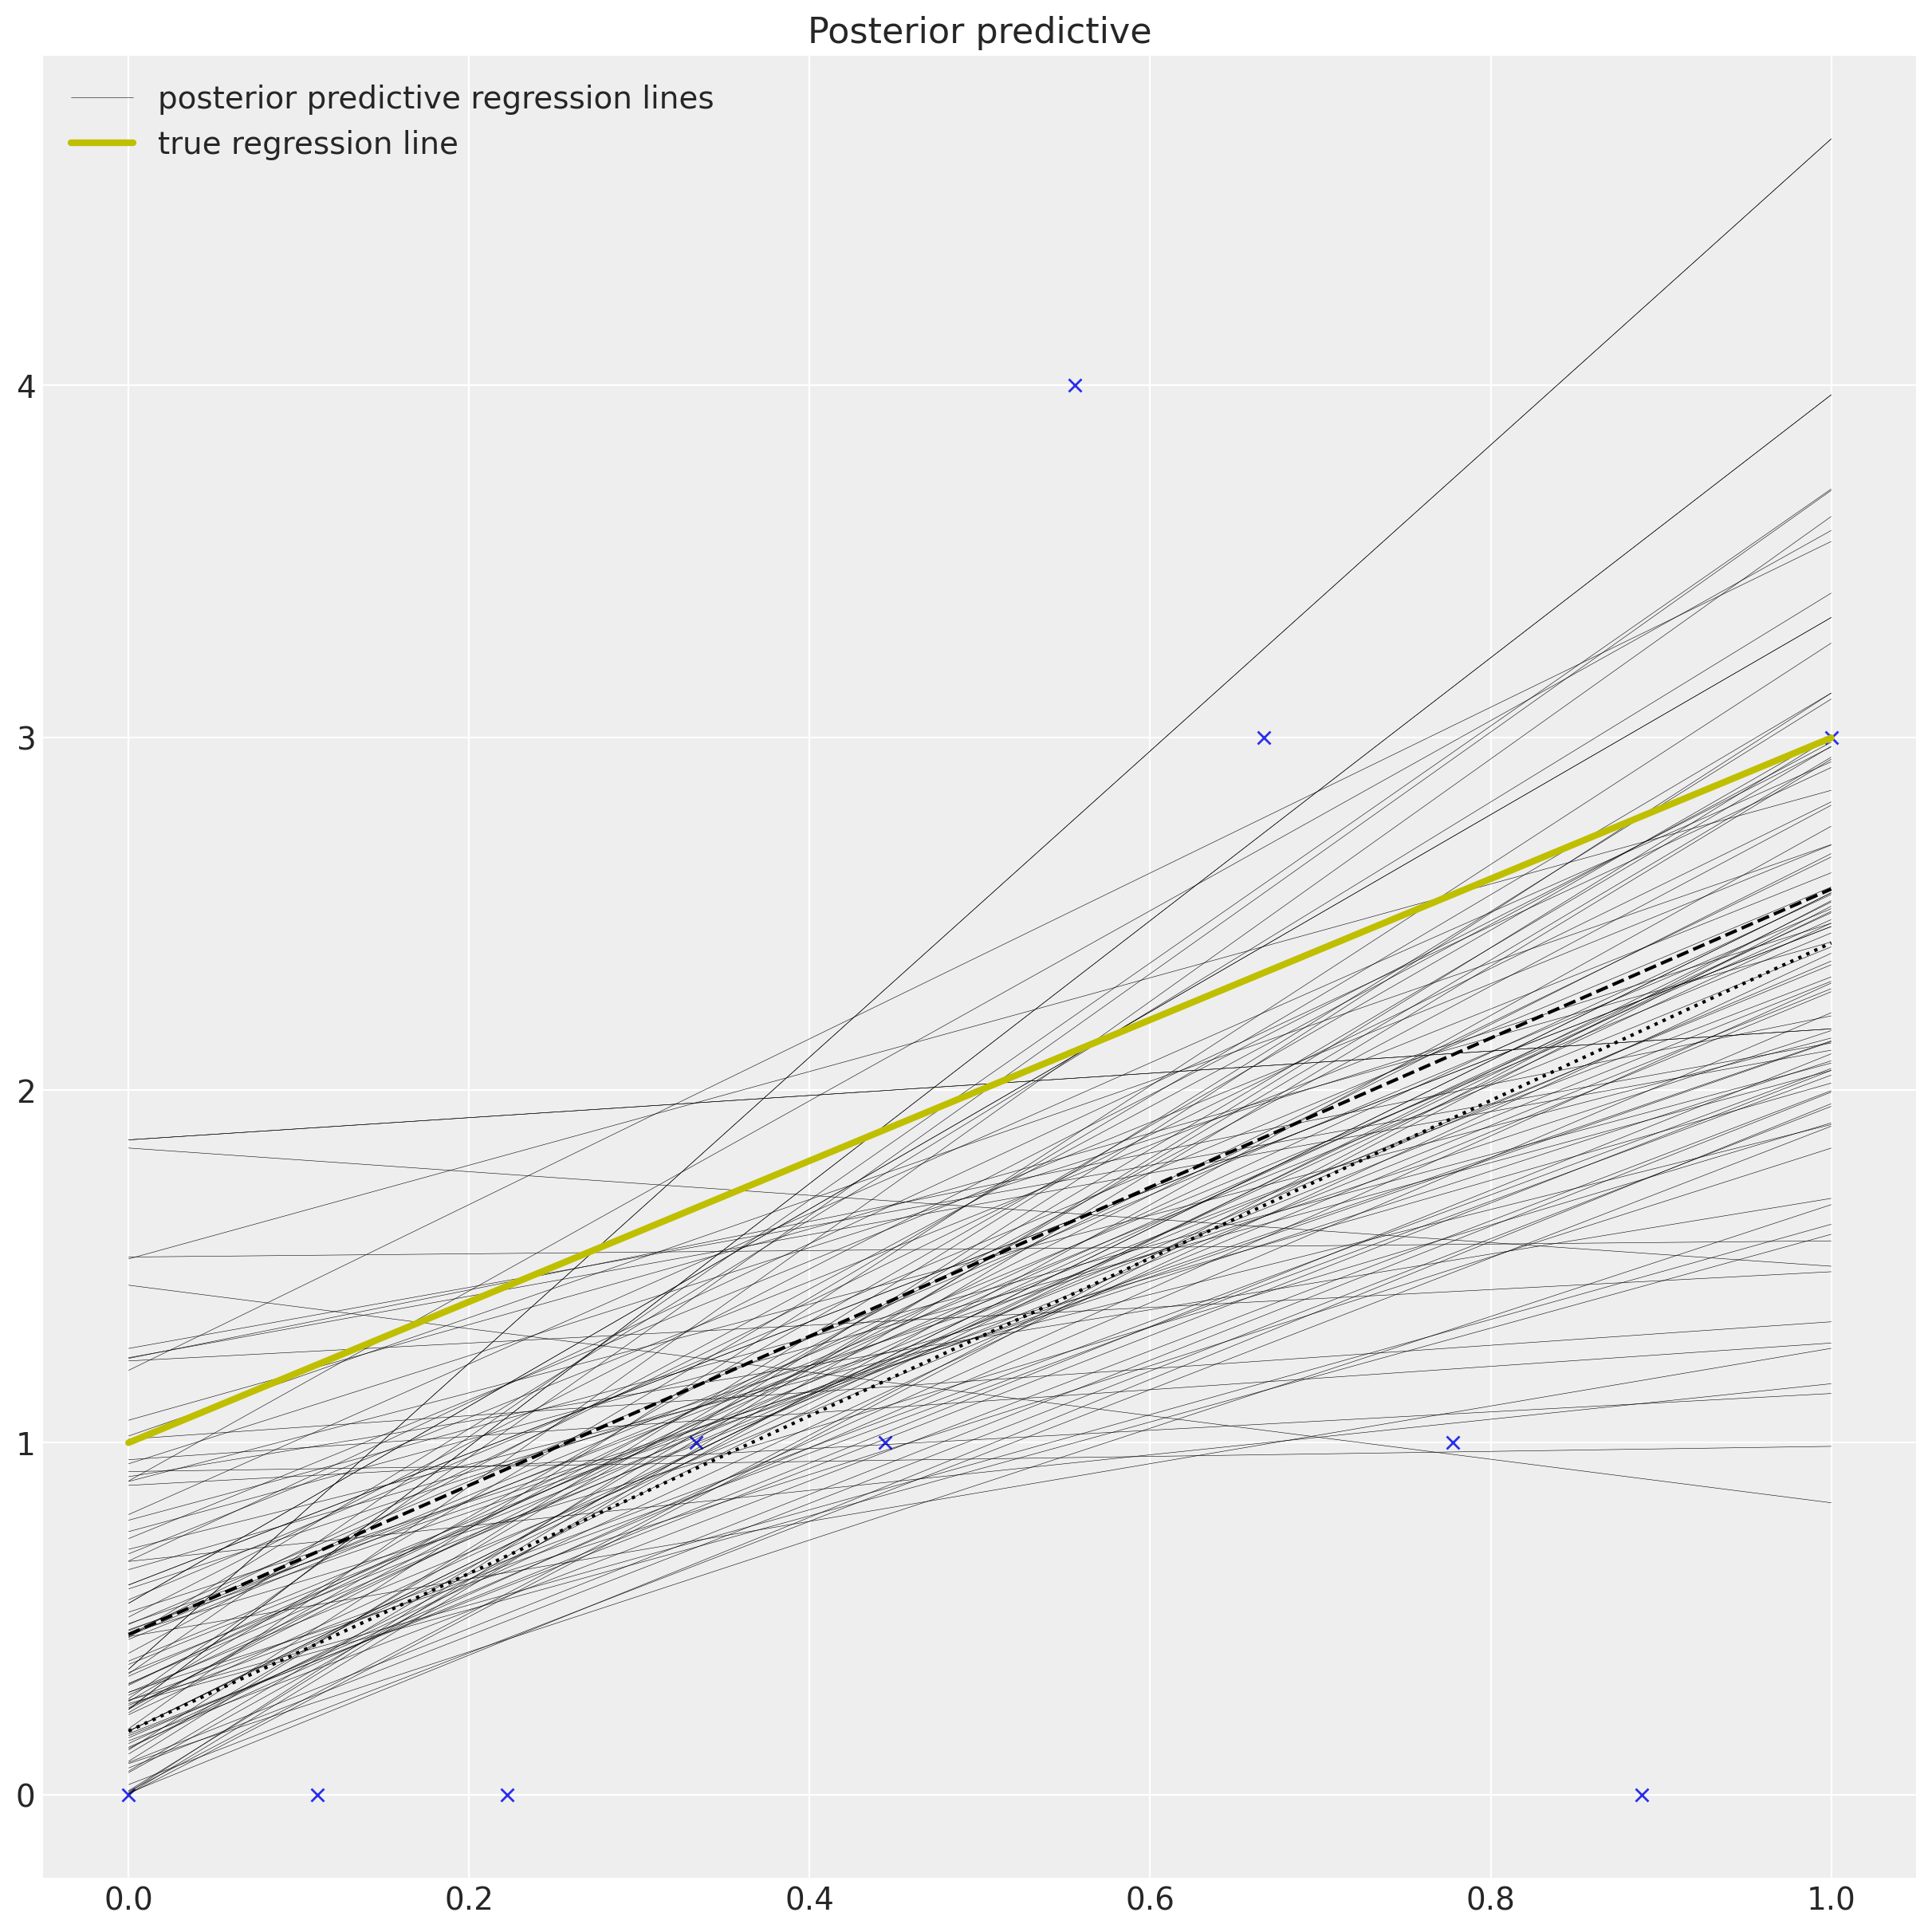

In [143]:
size = 10
true_intercept = 1
true_slope = 2

x = np.linspace(0, 1, size)
# y = a + b*x
true_regression_line = true_intercept + true_slope * x
# add noise
y =np.random.poisson(lam=true_regression_line)

# Add outliers
# x_out = np.append(x, [.1, .15, .2])
# y_out = np.append(y, [8, 6, 9])

data = dict(x=x, y=y)

m,b,r,stderr,bstderr=linregress(x,y)
m,b

with pm.Model() as model_robust:
    # Define priors
    intercept = pm.Normal("Intercept", mu=5, sd=20)
    x_coeff = pm.Normal("x", 5, sd=20)

    # Define likelihood
    likelihood = pm.Poisson("y", mu=intercept + x_coeff * x, observed=y)

    # Inference!
    trace = pm.sample(tune=2000)  # draw posterior samples using NUTS sampling

plt.figure(figsize=(12, 12))
plt.plot(x, y, 'x')
plot_posterior_predictive_glm(trace, samples=100, label="posterior predictive regression lines")
plt.plot(x, true_regression_line, 
         label='true regression line', lw=3., c='y')
plt.plot(x,m*x+b,'k:')
trs=pm.summary(trace)
plt.plot(x,trs['mean']['x']*x+trs['mean']['Intercept'],'k--')
plt.legend();

In [5]:
size = 200
true_intercept = 1
true_slope = 2

x = np.linspace(0, 1, size)
# y = a + b*x
true_regression_line = true_intercept + true_slope * x
# add noise
y = true_regression_line + np.random.normal(scale=0.5, size=size)

data = dict(x=x, y=y)

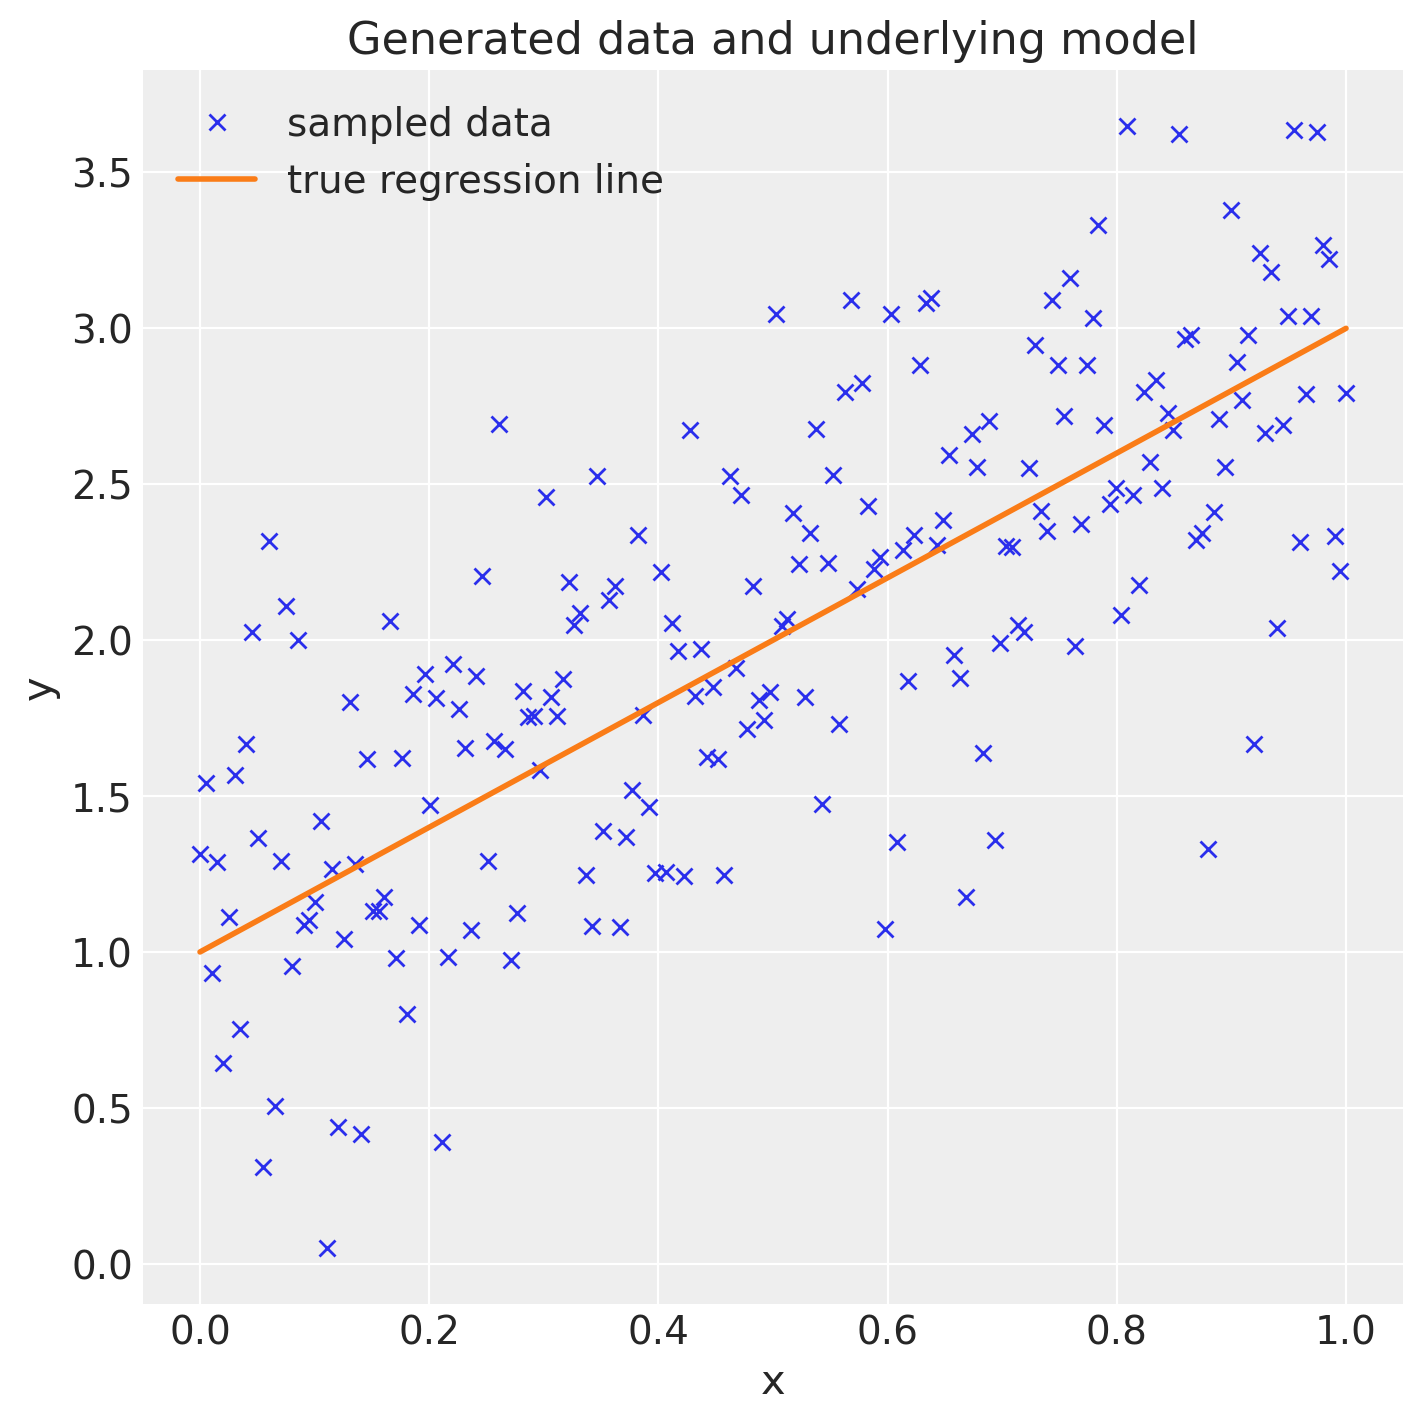

In [6]:
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111, xlabel="x", ylabel="y", title="Generated data and underlying model")
ax.plot(x, y, "x", label="sampled data")
ax.plot(x, true_regression_line, label="true regression line", lw=2.0)
plt.legend(loc=0);

In [16]:
with pm.Model() as model:  # model specifications in PyMC3 are wrapped in a with-statement
    # Define priors
    sd = pm.HalfCauchy("sigma", beta=10, testval=1.0)
    intercept = pm.Normal("Intercept", mu=0, sd=20)
    x_coeff = pm.Normal("x", 0, sd=20)

    # Define likelihood
    likelihood = pm.Normal("y", mu=intercept + x_coeff * x, sd=sd, observed=y)

    # Inference!
    trace = pm.sample(5000, cores=2)  # draw 3000 posterior samples using NUTS sampling

/var/folders/h1/c6fm27mx0_s2s16rjtynr_hw0000gn/T/ipykernel_87541/1056619431.py:11: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(5000, cores=2)  # draw 3000 posterior samples using NUTS sampling
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [x, Intercept, sigma]


Sampling 2 chains for 1_000 tune and 5_000 draw iterations (2_000 + 10_000 draws total) took 10 seconds.
The acceptance probability does not match the target. It is 0.8823881785314648, but should be close to 0.8. Try to increase the number of tuning steps.


In [13]:
with Model() as model:
    # specify glm and pass in data. The resulting linear model, its likelihood and
    # and all its parameters are automatically added to our model.
    glm.GLM.from_formula("y ~ x", data)
    trace = sample(3000, cores=2)  # draw 3000 posterior samples using NUTS sampling

/var/folders/h1/c6fm27mx0_s2s16rjtynr_hw0000gn/T/ipykernel_87541/322598603.py:5: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = sample(3000, cores=2)  # draw 3000 posterior samples using NUTS sampling
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sd, x, Intercept]


Sampling 2 chains for 1_000 tune and 3_000 draw iterations (2_000 + 6_000 draws total) took 8 seconds.
The acceptance probability does not match the target. It is 0.8831826463748215, but should be close to 0.8. Try to increase the number of tuning steps.


/opt/miniconda3/envs/fitting2/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
/var/folders/h1/c6fm27mx0_s2s16rjtynr_hw0000gn/T/ipykernel_87541/68747536.py:3: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plt.tight_layout();


<Figure size 700x700 with 0 Axes>

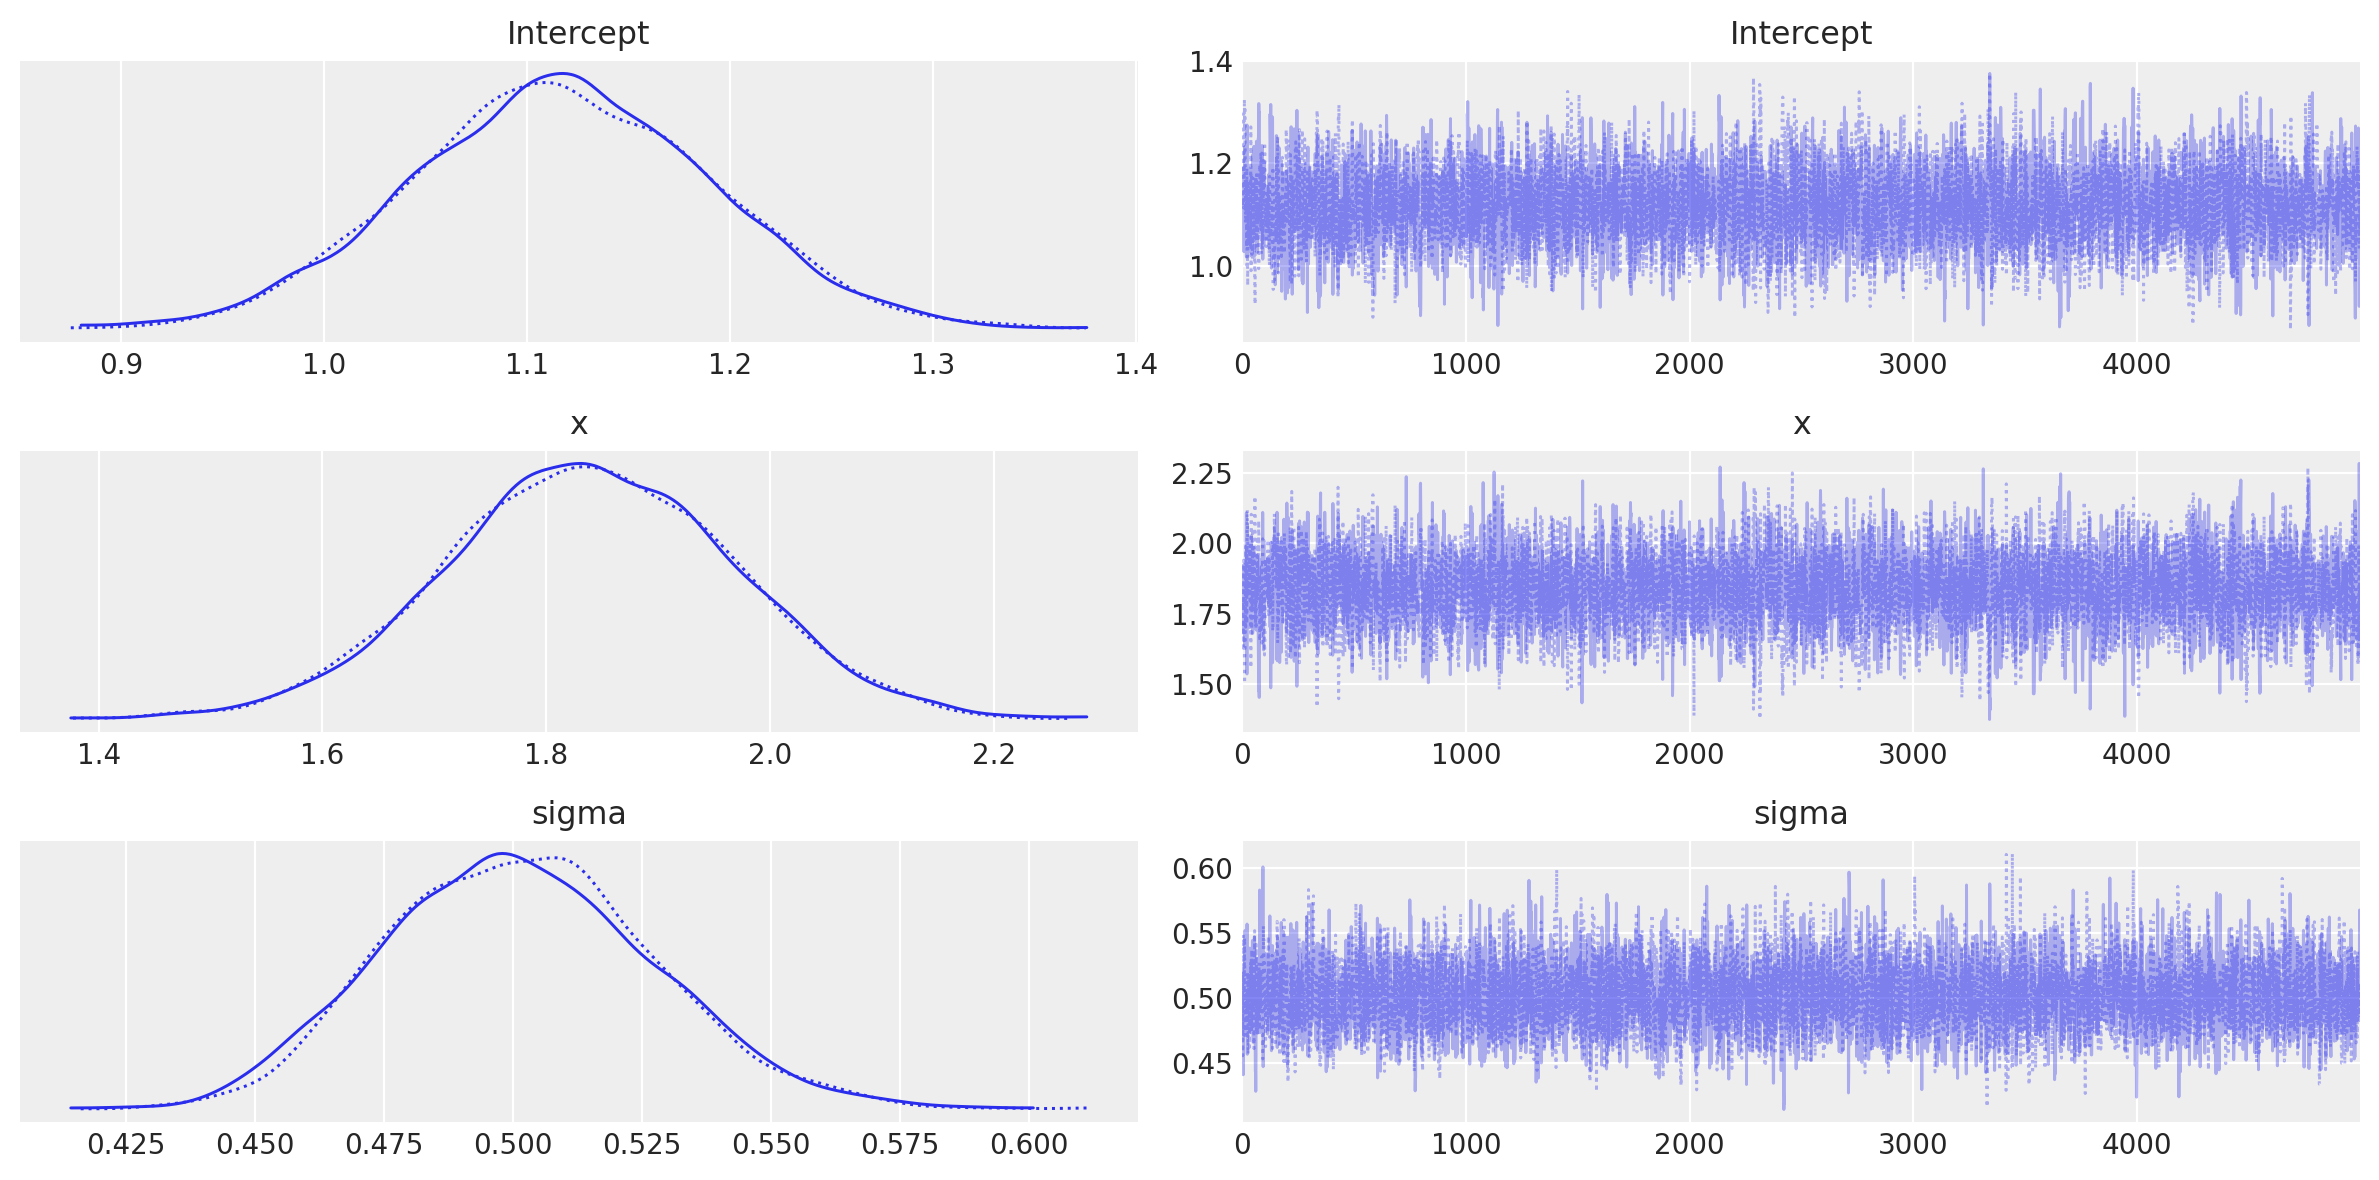

In [17]:
plt.figure(figsize=(7, 7))
pm.plot_trace(trace)
plt.tight_layout();

In [27]:
np.random.poisson(lam=1, size=size)

array([0, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 0, 2, 0, 2, 2, 1, 0, 0, 3, 1,
       1, 0, 4, 1, 0, 0, 1, 2, 0, 0, 3, 0, 1, 1, 0, 0, 1, 1, 1, 2, 0, 0,
       1, 1, 1, 0, 1, 2, 0, 2, 0, 2, 0, 1, 3, 0, 1, 1, 1, 1, 1, 0, 0, 1,
       0, 0, 1, 3, 3, 0, 2, 0, 2, 2, 2, 0, 1, 1, 0, 1, 3, 1, 0, 2, 1, 0,
       2, 0, 1, 1, 1, 0, 1, 0, 1, 2, 0, 1])

In [147]:
from scipy.stats import linregress
import time

In [154]:
# m_list=[]
# b_list=[]
# pm_list=[]
# pb_list=[]
ta=time.time()
for i in range(40):
    t1=time.time()
    size = 10
    true_intercept = 1
    true_slope = 2

    x = np.linspace(0, 1, size)
    # y = a + b*x
    true_regression_line = true_intercept + true_slope * x
    # add noise
    y =np.random.poisson(lam=true_regression_line)

    # Add outliers
    # x_out = np.append(x, [.1, .15, .2])
    # y_out = np.append(y, [8, 6, 9])

    data = dict(x=x, y=y)

    m,b,r,stderr,bstderr=linregress(x,y)
    m_list.append(m)
    b_list.append(b)

    with pm.Model() as model_robust:
        # Define priors
        intercept = pm.Normal("Intercept", mu=5, sd=20)
        x_coeff = pm.Normal("x", 5, sd=20)

        # Define likelihood
        likelihood = pm.Poisson("y", mu=intercept + x_coeff * x, observed=y)

        # Inference!
        trace = pm.sample(tune=2000)  # draw posterior samples using NUTS sampling
    
    trs=pm.summary(trace)
    pm_list.append(trs['mean']['x'])
    pb_list.append(trs['mean']['Intercept'])
    t2=time.time()
    print(t2-t1)
tb=time.time()
print(tb-ta)
    

/var/folders/h1/c6fm27mx0_s2s16rjtynr_hw0000gn/T/ipykernel_87541/3308707370.py:37: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(tune=2000)  # draw posterior samples using NUTS sampling
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [x, Intercept]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 11 seconds.
There were 88 divergences after tuning. Increase `target_accept` or reparameterize.
There were 34 divergences after tuning. Increase `target_accept` or reparameterize.
There were 49 divergences after tuning. Increase `target_accept` or reparameterize.
There were 50 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/opt/miniconda3/envs/fitting2/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


12.774774074554443


/var/folders/h1/c6fm27mx0_s2s16rjtynr_hw0000gn/T/ipykernel_87541/3308707370.py:37: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(tune=2000)  # draw posterior samples using NUTS sampling
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [x, Intercept]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 11 seconds.
There were 67 divergences after tuning. Increase `target_accept` or reparameterize.
There were 33 divergences after tuning. Increase `target_accept` or reparameterize.
There were 61 divergences after tuning. Increase `target_accept` or reparameterize.
There were 23 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.9050585278543521, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
/opt/miniconda3/envs/fitting2/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warni

13.255855798721313


/var/folders/h1/c6fm27mx0_s2s16rjtynr_hw0000gn/T/ipykernel_87541/3308707370.py:37: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(tune=2000)  # draw posterior samples using NUTS sampling
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [x, Intercept]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 12 seconds.
There were 524 divergences after tuning. Increase `target_accept` or reparameterize.
There were 562 divergences after tuning. Increase `target_accept` or reparameterize.
There were 562 divergences after tuning. Increase `target_accept` or reparameterize.
There were 556 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
/opt/miniconda3/envs/fitting2/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


13.94723892211914


/var/folders/h1/c6fm27mx0_s2s16rjtynr_hw0000gn/T/ipykernel_87541/3308707370.py:37: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(tune=2000)  # draw posterior samples using NUTS sampling
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [x, Intercept]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 11 seconds.
There were 57 divergences after tuning. Increase `target_accept` or reparameterize.
There were 45 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8911350112855362, but should be close to 0.8. Try to increase the number of tuning steps.
There were 74 divergences after tuning. Increase `target_accept` or reparameterize.
There were 83 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/opt/miniconda3/envs/fitting2/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warni

13.76855206489563


/var/folders/h1/c6fm27mx0_s2s16rjtynr_hw0000gn/T/ipykernel_87541/3308707370.py:37: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(tune=2000)  # draw posterior samples using NUTS sampling
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [x, Intercept]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 12 seconds.
There were 48 divergences after tuning. Increase `target_accept` or reparameterize.
There were 16 divergences after tuning. Increase `target_accept` or reparameterize.
There were 22 divergences after tuning. Increase `target_accept` or reparameterize.
There were 35 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/opt/miniconda3/envs/fitting2/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


13.907142877578735


/var/folders/h1/c6fm27mx0_s2s16rjtynr_hw0000gn/T/ipykernel_87541/3308707370.py:37: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(tune=2000)  # draw posterior samples using NUTS sampling
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [x, Intercept]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 12 seconds.
There were 71 divergences after tuning. Increase `target_accept` or reparameterize.
There were 48 divergences after tuning. Increase `target_accept` or reparameterize.
There were 45 divergences after tuning. Increase `target_accept` or reparameterize.
There were 58 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/opt/miniconda3/envs/fitting2/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


14.004455089569092


/var/folders/h1/c6fm27mx0_s2s16rjtynr_hw0000gn/T/ipykernel_87541/3308707370.py:37: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(tune=2000)  # draw posterior samples using NUTS sampling
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [x, Intercept]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 11 seconds.
There were 14 divergences after tuning. Increase `target_accept` or reparameterize.
There were 15 divergences after tuning. Increase `target_accept` or reparameterize.
There were 18 divergences after tuning. Increase `target_accept` or reparameterize.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/opt/miniconda3/envs/fitting2/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


12.939058780670166


/var/folders/h1/c6fm27mx0_s2s16rjtynr_hw0000gn/T/ipykernel_87541/3308707370.py:37: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(tune=2000)  # draw posterior samples using NUTS sampling
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [x, Intercept]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 11 seconds.
There were 168 divergences after tuning. Increase `target_accept` or reparameterize.
There were 143 divergences after tuning. Increase `target_accept` or reparameterize.
There were 159 divergences after tuning. Increase `target_accept` or reparameterize.
There were 173 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/opt/miniconda3/envs/fitting2/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


12.63717794418335


/var/folders/h1/c6fm27mx0_s2s16rjtynr_hw0000gn/T/ipykernel_87541/3308707370.py:37: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(tune=2000)  # draw posterior samples using NUTS sampling
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [x, Intercept]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 11 seconds.
There were 276 divergences after tuning. Increase `target_accept` or reparameterize.
There were 245 divergences after tuning. Increase `target_accept` or reparameterize.
There were 277 divergences after tuning. Increase `target_accept` or reparameterize.
There were 258 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8786700787887524, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
/opt/miniconda3/envs/fitting2/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  w

12.820822954177856


/var/folders/h1/c6fm27mx0_s2s16rjtynr_hw0000gn/T/ipykernel_87541/3308707370.py:37: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(tune=2000)  # draw posterior samples using NUTS sampling
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [x, Intercept]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 12 seconds.
There were 421 divergences after tuning. Increase `target_accept` or reparameterize.
There were 412 divergences after tuning. Increase `target_accept` or reparameterize.
There were 445 divergences after tuning. Increase `target_accept` or reparameterize.
There were 462 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/opt/miniconda3/envs/fitting2/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


14.043219089508057


/var/folders/h1/c6fm27mx0_s2s16rjtynr_hw0000gn/T/ipykernel_87541/3308707370.py:37: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(tune=2000)  # draw posterior samples using NUTS sampling
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [x, Intercept]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 11 seconds.
There were 25 divergences after tuning. Increase `target_accept` or reparameterize.
There were 30 divergences after tuning. Increase `target_accept` or reparameterize.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
There were 19 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/opt/miniconda3/envs/fitting2/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


12.765790939331055


/var/folders/h1/c6fm27mx0_s2s16rjtynr_hw0000gn/T/ipykernel_87541/3308707370.py:37: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(tune=2000)  # draw posterior samples using NUTS sampling
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [x, Intercept]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 11 seconds.
There were 235 divergences after tuning. Increase `target_accept` or reparameterize.
There were 156 divergences after tuning. Increase `target_accept` or reparameterize.
There were 190 divergences after tuning. Increase `target_accept` or reparameterize.
There were 203 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/opt/miniconda3/envs/fitting2/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


13.16847276687622


/var/folders/h1/c6fm27mx0_s2s16rjtynr_hw0000gn/T/ipykernel_87541/3308707370.py:37: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(tune=2000)  # draw posterior samples using NUTS sampling
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [x, Intercept]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 12 seconds.
There were 112 divergences after tuning. Increase `target_accept` or reparameterize.
There were 153 divergences after tuning. Increase `target_accept` or reparameterize.
There were 126 divergences after tuning. Increase `target_accept` or reparameterize.
There were 177 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6820437625996858, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
/opt/miniconda3/envs/fitting2/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  w

13.592039108276367


/var/folders/h1/c6fm27mx0_s2s16rjtynr_hw0000gn/T/ipykernel_87541/3308707370.py:37: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(tune=2000)  # draw posterior samples using NUTS sampling
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [x, Intercept]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 12 seconds.
There were 385 divergences after tuning. Increase `target_accept` or reparameterize.
There were 401 divergences after tuning. Increase `target_accept` or reparameterize.
There were 374 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8799669702670274, but should be close to 0.8. Try to increase the number of tuning steps.
There were 362 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/opt/miniconda3/envs/fitting2/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  w

13.573161840438843


/var/folders/h1/c6fm27mx0_s2s16rjtynr_hw0000gn/T/ipykernel_87541/3308707370.py:37: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(tune=2000)  # draw posterior samples using NUTS sampling
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [x, Intercept]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 11 seconds.
There were 732 divergences after tuning. Increase `target_accept` or reparameterize.
There were 701 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7147230505764189, but should be close to 0.8. Try to increase the number of tuning steps.
There were 589 divergences after tuning. Increase `target_accept` or reparameterize.
There were 648 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
/opt/miniconda3/envs/fitting2/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  w

12.64985179901123


/var/folders/h1/c6fm27mx0_s2s16rjtynr_hw0000gn/T/ipykernel_87541/3308707370.py:37: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(tune=2000)  # draw posterior samples using NUTS sampling
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [x, Intercept]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 11 seconds.
There were 33 divergences after tuning. Increase `target_accept` or reparameterize.
There were 25 divergences after tuning. Increase `target_accept` or reparameterize.
There were 23 divergences after tuning. Increase `target_accept` or reparameterize.
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8885755009470023, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
/opt/miniconda3/envs/fitting2/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warni

13.139974117279053


/var/folders/h1/c6fm27mx0_s2s16rjtynr_hw0000gn/T/ipykernel_87541/3308707370.py:37: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(tune=2000)  # draw posterior samples using NUTS sampling
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [x, Intercept]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 11 seconds.
There were 576 divergences after tuning. Increase `target_accept` or reparameterize.
There were 606 divergences after tuning. Increase `target_accept` or reparameterize.
There were 550 divergences after tuning. Increase `target_accept` or reparameterize.
There were 581 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
/opt/miniconda3/envs/fitting2/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


12.583570718765259


/var/folders/h1/c6fm27mx0_s2s16rjtynr_hw0000gn/T/ipykernel_87541/3308707370.py:37: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(tune=2000)  # draw posterior samples using NUTS sampling
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [x, Intercept]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 11 seconds.
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
There were 24 divergences after tuning. Increase `target_accept` or reparameterize.
There were 19 divergences after tuning. Increase `target_accept` or reparameterize.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8887138360472471, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
/opt/miniconda3/envs/fitting2/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnin

12.993601083755493


/var/folders/h1/c6fm27mx0_s2s16rjtynr_hw0000gn/T/ipykernel_87541/3308707370.py:37: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(tune=2000)  # draw posterior samples using NUTS sampling
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [x, Intercept]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 11 seconds.
There were 114 divergences after tuning. Increase `target_accept` or reparameterize.
There were 114 divergences after tuning. Increase `target_accept` or reparameterize.
There were 73 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8880287684859739, but should be close to 0.8. Try to increase the number of tuning steps.
There were 142 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/opt/miniconda3/envs/fitting2/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  wa

13.104782104492188


/var/folders/h1/c6fm27mx0_s2s16rjtynr_hw0000gn/T/ipykernel_87541/3308707370.py:37: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(tune=2000)  # draw posterior samples using NUTS sampling
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [x, Intercept]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 12 seconds.
There were 158 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8852566362158445, but should be close to 0.8. Try to increase the number of tuning steps.
There were 158 divergences after tuning. Increase `target_accept` or reparameterize.
There were 181 divergences after tuning. Increase `target_accept` or reparameterize.
There were 119 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8942265596168668, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
/opt/miniconda3/envs/fitting2/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. No

14.04154896736145


/var/folders/h1/c6fm27mx0_s2s16rjtynr_hw0000gn/T/ipykernel_87541/3308707370.py:37: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(tune=2000)  # draw posterior samples using NUTS sampling
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [x, Intercept]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 11 seconds.
There were 286 divergences after tuning. Increase `target_accept` or reparameterize.
There were 270 divergences after tuning. Increase `target_accept` or reparameterize.
There were 289 divergences after tuning. Increase `target_accept` or reparameterize.
There were 318 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/opt/miniconda3/envs/fitting2/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


13.058122873306274


/var/folders/h1/c6fm27mx0_s2s16rjtynr_hw0000gn/T/ipykernel_87541/3308707370.py:37: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(tune=2000)  # draw posterior samples using NUTS sampling
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [x, Intercept]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 11 seconds.
There were 249 divergences after tuning. Increase `target_accept` or reparameterize.
There were 269 divergences after tuning. Increase `target_accept` or reparameterize.
There were 333 divergences after tuning. Increase `target_accept` or reparameterize.
There were 345 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/opt/miniconda3/envs/fitting2/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


13.385906219482422


/var/folders/h1/c6fm27mx0_s2s16rjtynr_hw0000gn/T/ipykernel_87541/3308707370.py:37: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(tune=2000)  # draw posterior samples using NUTS sampling
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [x, Intercept]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 11 seconds.
There were 109 divergences after tuning. Increase `target_accept` or reparameterize.
There were 66 divergences after tuning. Increase `target_accept` or reparameterize.
There were 64 divergences after tuning. Increase `target_accept` or reparameterize.
There were 79 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/opt/miniconda3/envs/fitting2/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


12.72540283203125


/var/folders/h1/c6fm27mx0_s2s16rjtynr_hw0000gn/T/ipykernel_87541/3308707370.py:37: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(tune=2000)  # draw posterior samples using NUTS sampling
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [x, Intercept]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 11 seconds.
There were 175 divergences after tuning. Increase `target_accept` or reparameterize.
There were 199 divergences after tuning. Increase `target_accept` or reparameterize.
There were 271 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7019783879239517, but should be close to 0.8. Try to increase the number of tuning steps.
There were 211 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/opt/miniconda3/envs/fitting2/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  w

13.43038010597229


/var/folders/h1/c6fm27mx0_s2s16rjtynr_hw0000gn/T/ipykernel_87541/3308707370.py:37: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(tune=2000)  # draw posterior samples using NUTS sampling
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [x, Intercept]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 11 seconds.
There were 615 divergences after tuning. Increase `target_accept` or reparameterize.
There were 587 divergences after tuning. Increase `target_accept` or reparameterize.
There were 574 divergences after tuning. Increase `target_accept` or reparameterize.
There were 593 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/opt/miniconda3/envs/fitting2/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


13.09811806678772


/var/folders/h1/c6fm27mx0_s2s16rjtynr_hw0000gn/T/ipykernel_87541/3308707370.py:37: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(tune=2000)  # draw posterior samples using NUTS sampling
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [x, Intercept]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 11 seconds.
There were 84 divergences after tuning. Increase `target_accept` or reparameterize.
There were 56 divergences after tuning. Increase `target_accept` or reparameterize.
There were 88 divergences after tuning. Increase `target_accept` or reparameterize.
There were 61 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/opt/miniconda3/envs/fitting2/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


12.926200151443481


/var/folders/h1/c6fm27mx0_s2s16rjtynr_hw0000gn/T/ipykernel_87541/3308707370.py:37: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(tune=2000)  # draw posterior samples using NUTS sampling
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [x, Intercept]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 11 seconds.
There were 133 divergences after tuning. Increase `target_accept` or reparameterize.
There were 165 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6943916510614053, but should be close to 0.8. Try to increase the number of tuning steps.
There were 90 divergences after tuning. Increase `target_accept` or reparameterize.
There were 111 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/opt/miniconda3/envs/fitting2/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  wa

12.682084321975708


/var/folders/h1/c6fm27mx0_s2s16rjtynr_hw0000gn/T/ipykernel_87541/3308707370.py:37: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(tune=2000)  # draw posterior samples using NUTS sampling
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [x, Intercept]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 11 seconds.
There were 55 divergences after tuning. Increase `target_accept` or reparameterize.
There were 29 divergences after tuning. Increase `target_accept` or reparameterize.
There were 68 divergences after tuning. Increase `target_accept` or reparameterize.
There were 125 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/opt/miniconda3/envs/fitting2/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


13.101336002349854


/var/folders/h1/c6fm27mx0_s2s16rjtynr_hw0000gn/T/ipykernel_87541/3308707370.py:37: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(tune=2000)  # draw posterior samples using NUTS sampling
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [x, Intercept]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 11 seconds.
There were 30 divergences after tuning. Increase `target_accept` or reparameterize.
There were 24 divergences after tuning. Increase `target_accept` or reparameterize.
There were 26 divergences after tuning. Increase `target_accept` or reparameterize.
There were 29 divergences after tuning. Increase `target_accept` or reparameterize.
/opt/miniconda3/envs/fitting2/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


12.639748096466064


/var/folders/h1/c6fm27mx0_s2s16rjtynr_hw0000gn/T/ipykernel_87541/3308707370.py:37: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(tune=2000)  # draw posterior samples using NUTS sampling
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [x, Intercept]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 15 seconds.
There were 120 divergences after tuning. Increase `target_accept` or reparameterize.
There were 127 divergences after tuning. Increase `target_accept` or reparameterize.
There were 158 divergences after tuning. Increase `target_accept` or reparameterize.
There were 134 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/opt/miniconda3/envs/fitting2/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


17.702027082443237


/var/folders/h1/c6fm27mx0_s2s16rjtynr_hw0000gn/T/ipykernel_87541/3308707370.py:37: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(tune=2000)  # draw posterior samples using NUTS sampling
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [x, Intercept]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 15 seconds.
There were 97 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.9087372103743465, but should be close to 0.8. Try to increase the number of tuning steps.
There were 155 divergences after tuning. Increase `target_accept` or reparameterize.
There were 120 divergences after tuning. Increase `target_accept` or reparameterize.
There were 165 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/opt/miniconda3/envs/fitting2/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  wa

17.23147201538086


/var/folders/h1/c6fm27mx0_s2s16rjtynr_hw0000gn/T/ipykernel_87541/3308707370.py:37: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(tune=2000)  # draw posterior samples using NUTS sampling
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [x, Intercept]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 11 seconds.
There were 39 divergences after tuning. Increase `target_accept` or reparameterize.
There were 35 divergences after tuning. Increase `target_accept` or reparameterize.
There were 64 divergences after tuning. Increase `target_accept` or reparameterize.
There were 55 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/opt/miniconda3/envs/fitting2/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


12.960222005844116


/var/folders/h1/c6fm27mx0_s2s16rjtynr_hw0000gn/T/ipykernel_87541/3308707370.py:37: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(tune=2000)  # draw posterior samples using NUTS sampling
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [x, Intercept]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 11 seconds.
There were 179 divergences after tuning. Increase `target_accept` or reparameterize.
There were 185 divergences after tuning. Increase `target_accept` or reparameterize.
There were 197 divergences after tuning. Increase `target_accept` or reparameterize.
There were 210 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/opt/miniconda3/envs/fitting2/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


12.735484838485718


/var/folders/h1/c6fm27mx0_s2s16rjtynr_hw0000gn/T/ipykernel_87541/3308707370.py:37: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(tune=2000)  # draw posterior samples using NUTS sampling
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [x, Intercept]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 13 seconds.
There were 48 divergences after tuning. Increase `target_accept` or reparameterize.
There were 51 divergences after tuning. Increase `target_accept` or reparameterize.
There were 86 divergences after tuning. Increase `target_accept` or reparameterize.
There were 62 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/opt/miniconda3/envs/fitting2/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


15.15671706199646


/var/folders/h1/c6fm27mx0_s2s16rjtynr_hw0000gn/T/ipykernel_87541/3308707370.py:37: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(tune=2000)  # draw posterior samples using NUTS sampling
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [x, Intercept]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 12 seconds.
There were 131 divergences after tuning. Increase `target_accept` or reparameterize.
There were 109 divergences after tuning. Increase `target_accept` or reparameterize.
There were 160 divergences after tuning. Increase `target_accept` or reparameterize.
There were 111 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/opt/miniconda3/envs/fitting2/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


14.27225112915039


/var/folders/h1/c6fm27mx0_s2s16rjtynr_hw0000gn/T/ipykernel_87541/3308707370.py:37: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(tune=2000)  # draw posterior samples using NUTS sampling
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [x, Intercept]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 11 seconds.
There were 38 divergences after tuning. Increase `target_accept` or reparameterize.
There were 13 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.9025355960113621, but should be close to 0.8. Try to increase the number of tuning steps.
There were 12 divergences after tuning. Increase `target_accept` or reparameterize.
There were 18 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/opt/miniconda3/envs/fitting2/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warni

12.834228992462158


/var/folders/h1/c6fm27mx0_s2s16rjtynr_hw0000gn/T/ipykernel_87541/3308707370.py:37: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(tune=2000)  # draw posterior samples using NUTS sampling
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [x, Intercept]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 12 seconds.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8867500358965159, but should be close to 0.8. Try to increase the number of tuning steps.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8867494732086034, but should be close to 0.8. Try to increase the number of tuning steps.
There were 26 divergences after tuning. Increase `target_accept` or reparameterize.
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/opt/miniconda3/envs/fitting2/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not usin

14.498366117477417


/var/folders/h1/c6fm27mx0_s2s16rjtynr_hw0000gn/T/ipykernel_87541/3308707370.py:37: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(tune=2000)  # draw posterior samples using NUTS sampling
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [x, Intercept]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 11 seconds.
There were 453 divergences after tuning. Increase `target_accept` or reparameterize.
There were 488 divergences after tuning. Increase `target_accept` or reparameterize.
There were 490 divergences after tuning. Increase `target_accept` or reparameterize.
There were 426 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
/opt/miniconda3/envs/fitting2/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


13.75403904914856


/var/folders/h1/c6fm27mx0_s2s16rjtynr_hw0000gn/T/ipykernel_87541/3308707370.py:37: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(tune=2000)  # draw posterior samples using NUTS sampling
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [x, Intercept]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 12 seconds.
There were 30 divergences after tuning. Increase `target_accept` or reparameterize.
There were 41 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7215200346604455, but should be close to 0.8. Try to increase the number of tuning steps.
There were 27 divergences after tuning. Increase `target_accept` or reparameterize.
There were 29 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/opt/miniconda3/envs/fitting2/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warni

13.94496464729309


/var/folders/h1/c6fm27mx0_s2s16rjtynr_hw0000gn/T/ipykernel_87541/3308707370.py:37: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(tune=2000)  # draw posterior samples using NUTS sampling
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [x, Intercept]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 11 seconds.
There were 491 divergences after tuning. Increase `target_accept` or reparameterize.
There were 588 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6734098260464205, but should be close to 0.8. Try to increase the number of tuning steps.
There were 492 divergences after tuning. Increase `target_accept` or reparameterize.
There were 534 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
/opt/miniconda3/envs/fitting2/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  w

12.660409212112427
540.5141997337341


In [151]:
print(np.abs(np.array(m_list)-2))
print(np.abs(np.array(b_list)-1))
print(np.abs(np.array(pm_list)-2))
print(np.abs(np.array(pb_list)-1))

[1.94545455 0.23636364 0.45454545 0.18181818 2.92727273 0.50909091
 0.69090909 0.83636364 0.03636364 1.27272727]
[0.87272727 0.41818182 0.27272727 0.29090909 0.96363636 0.45454545
 0.14545455 1.01818182 0.78181818 1.23636364]
[1.759 0.333 0.021 0.469 2.796 0.16  1.126 0.102 0.533 0.168]
[0.976 0.07  0.702 0.218 1.097 0.066 0.575 0.332 0.32  0.489]


In [155]:
print(np.median(np.abs(np.array(m_list)-2)))
print(np.median(np.abs(np.array(b_list)-1)))
print(np.median(np.abs(np.array(pm_list)-2)))
print(np.median(np.abs(np.array(pb_list)-1)))

0.8636363636363635
0.5000000000000001
0.763
0.35750000000000004


In [152]:
np.array(m_list)

array([ 0.05454545,  2.23636364,  2.45454545,  2.18181818, -0.92727273,
        2.50909091,  1.30909091,  2.83636364,  1.96363636,  3.27272727])

/opt/miniconda3/envs/fitting2/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


array([[<AxesSubplot:title={'center':'Intercept'}>,
        <AxesSubplot:title={'center':'Intercept'}>],
       [<AxesSubplot:title={'center':'x'}>,
        <AxesSubplot:title={'center':'x'}>]], dtype=object)

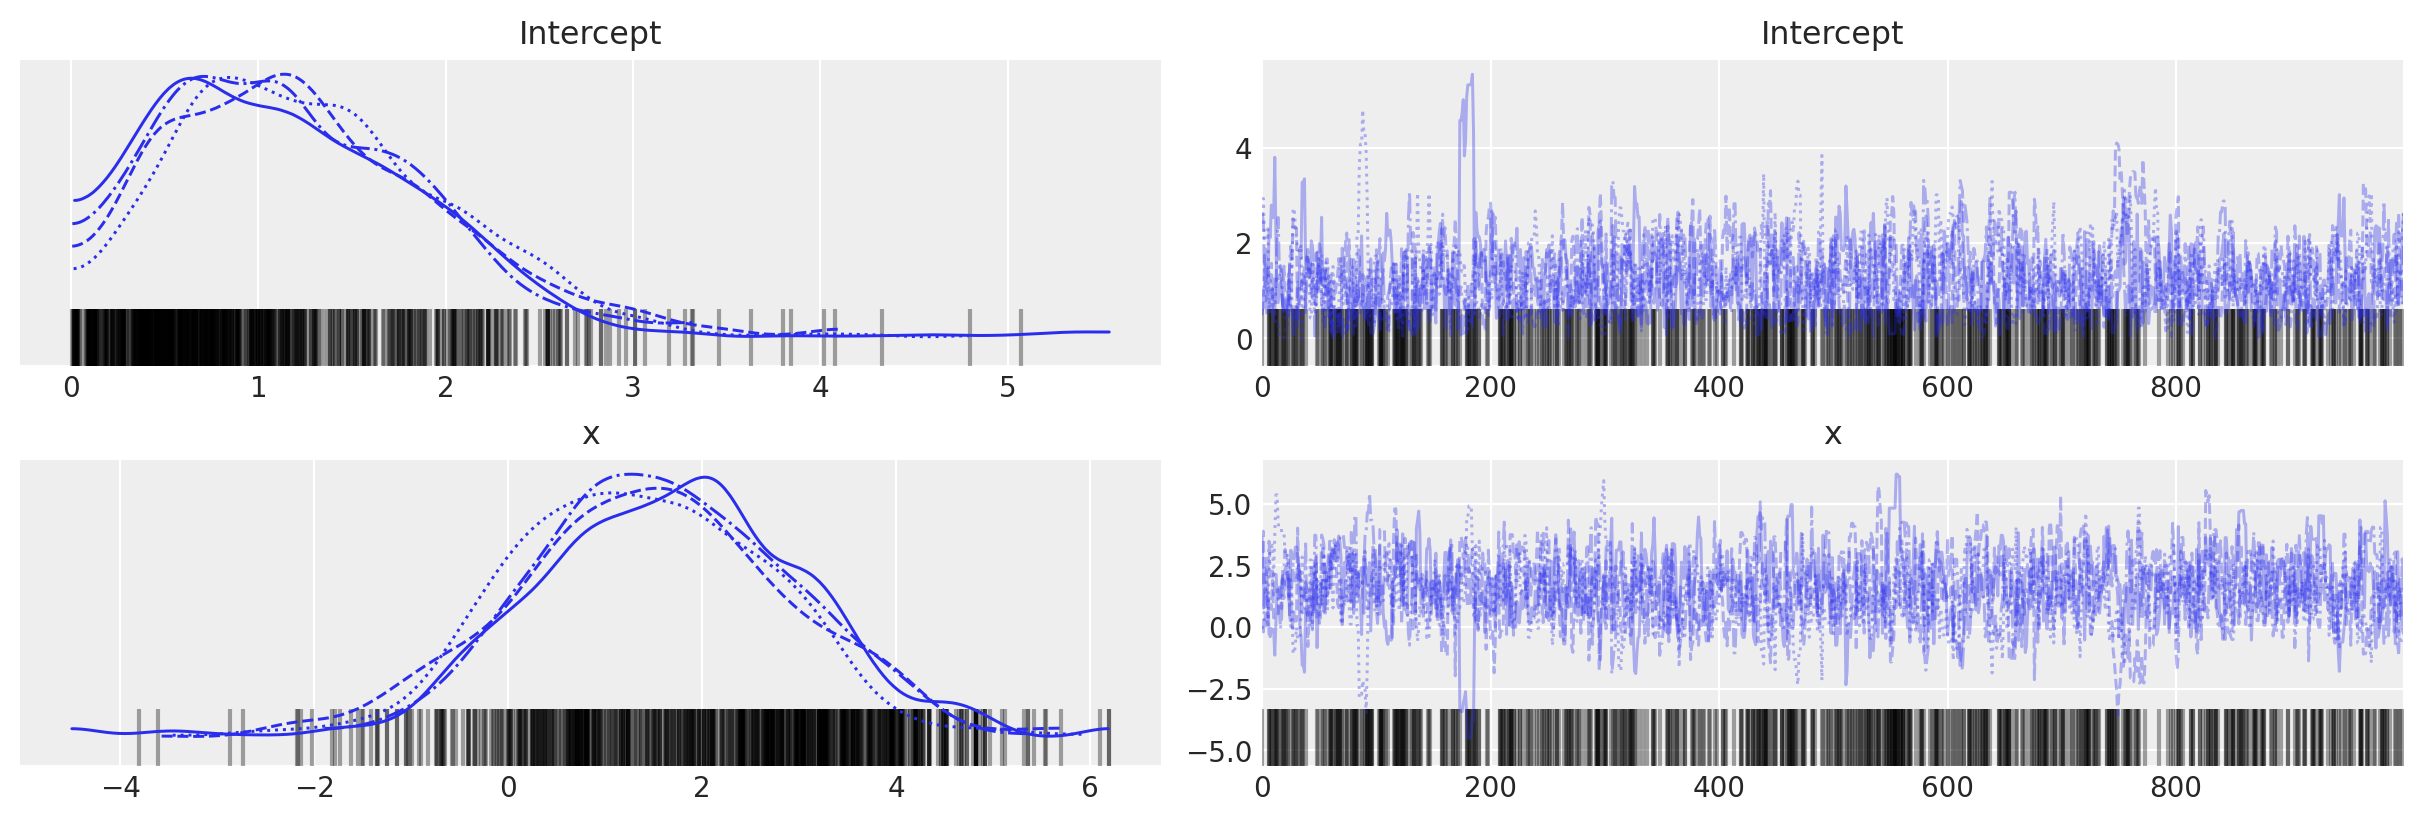

In [131]:
plot_trace(trace)

/opt/miniconda3/envs/fitting2/lib/python3.9/site-packages/pymc3/plots/posteriorplot.py:59: DeprecationWarning: The `plot_posterior_predictive_glm` function will migrate to Arviz in a future release. 
Keep up to date with `ArviZ <https://arviz-devs.github.io/arviz/>`_ for future updates.
  warnings.warn(


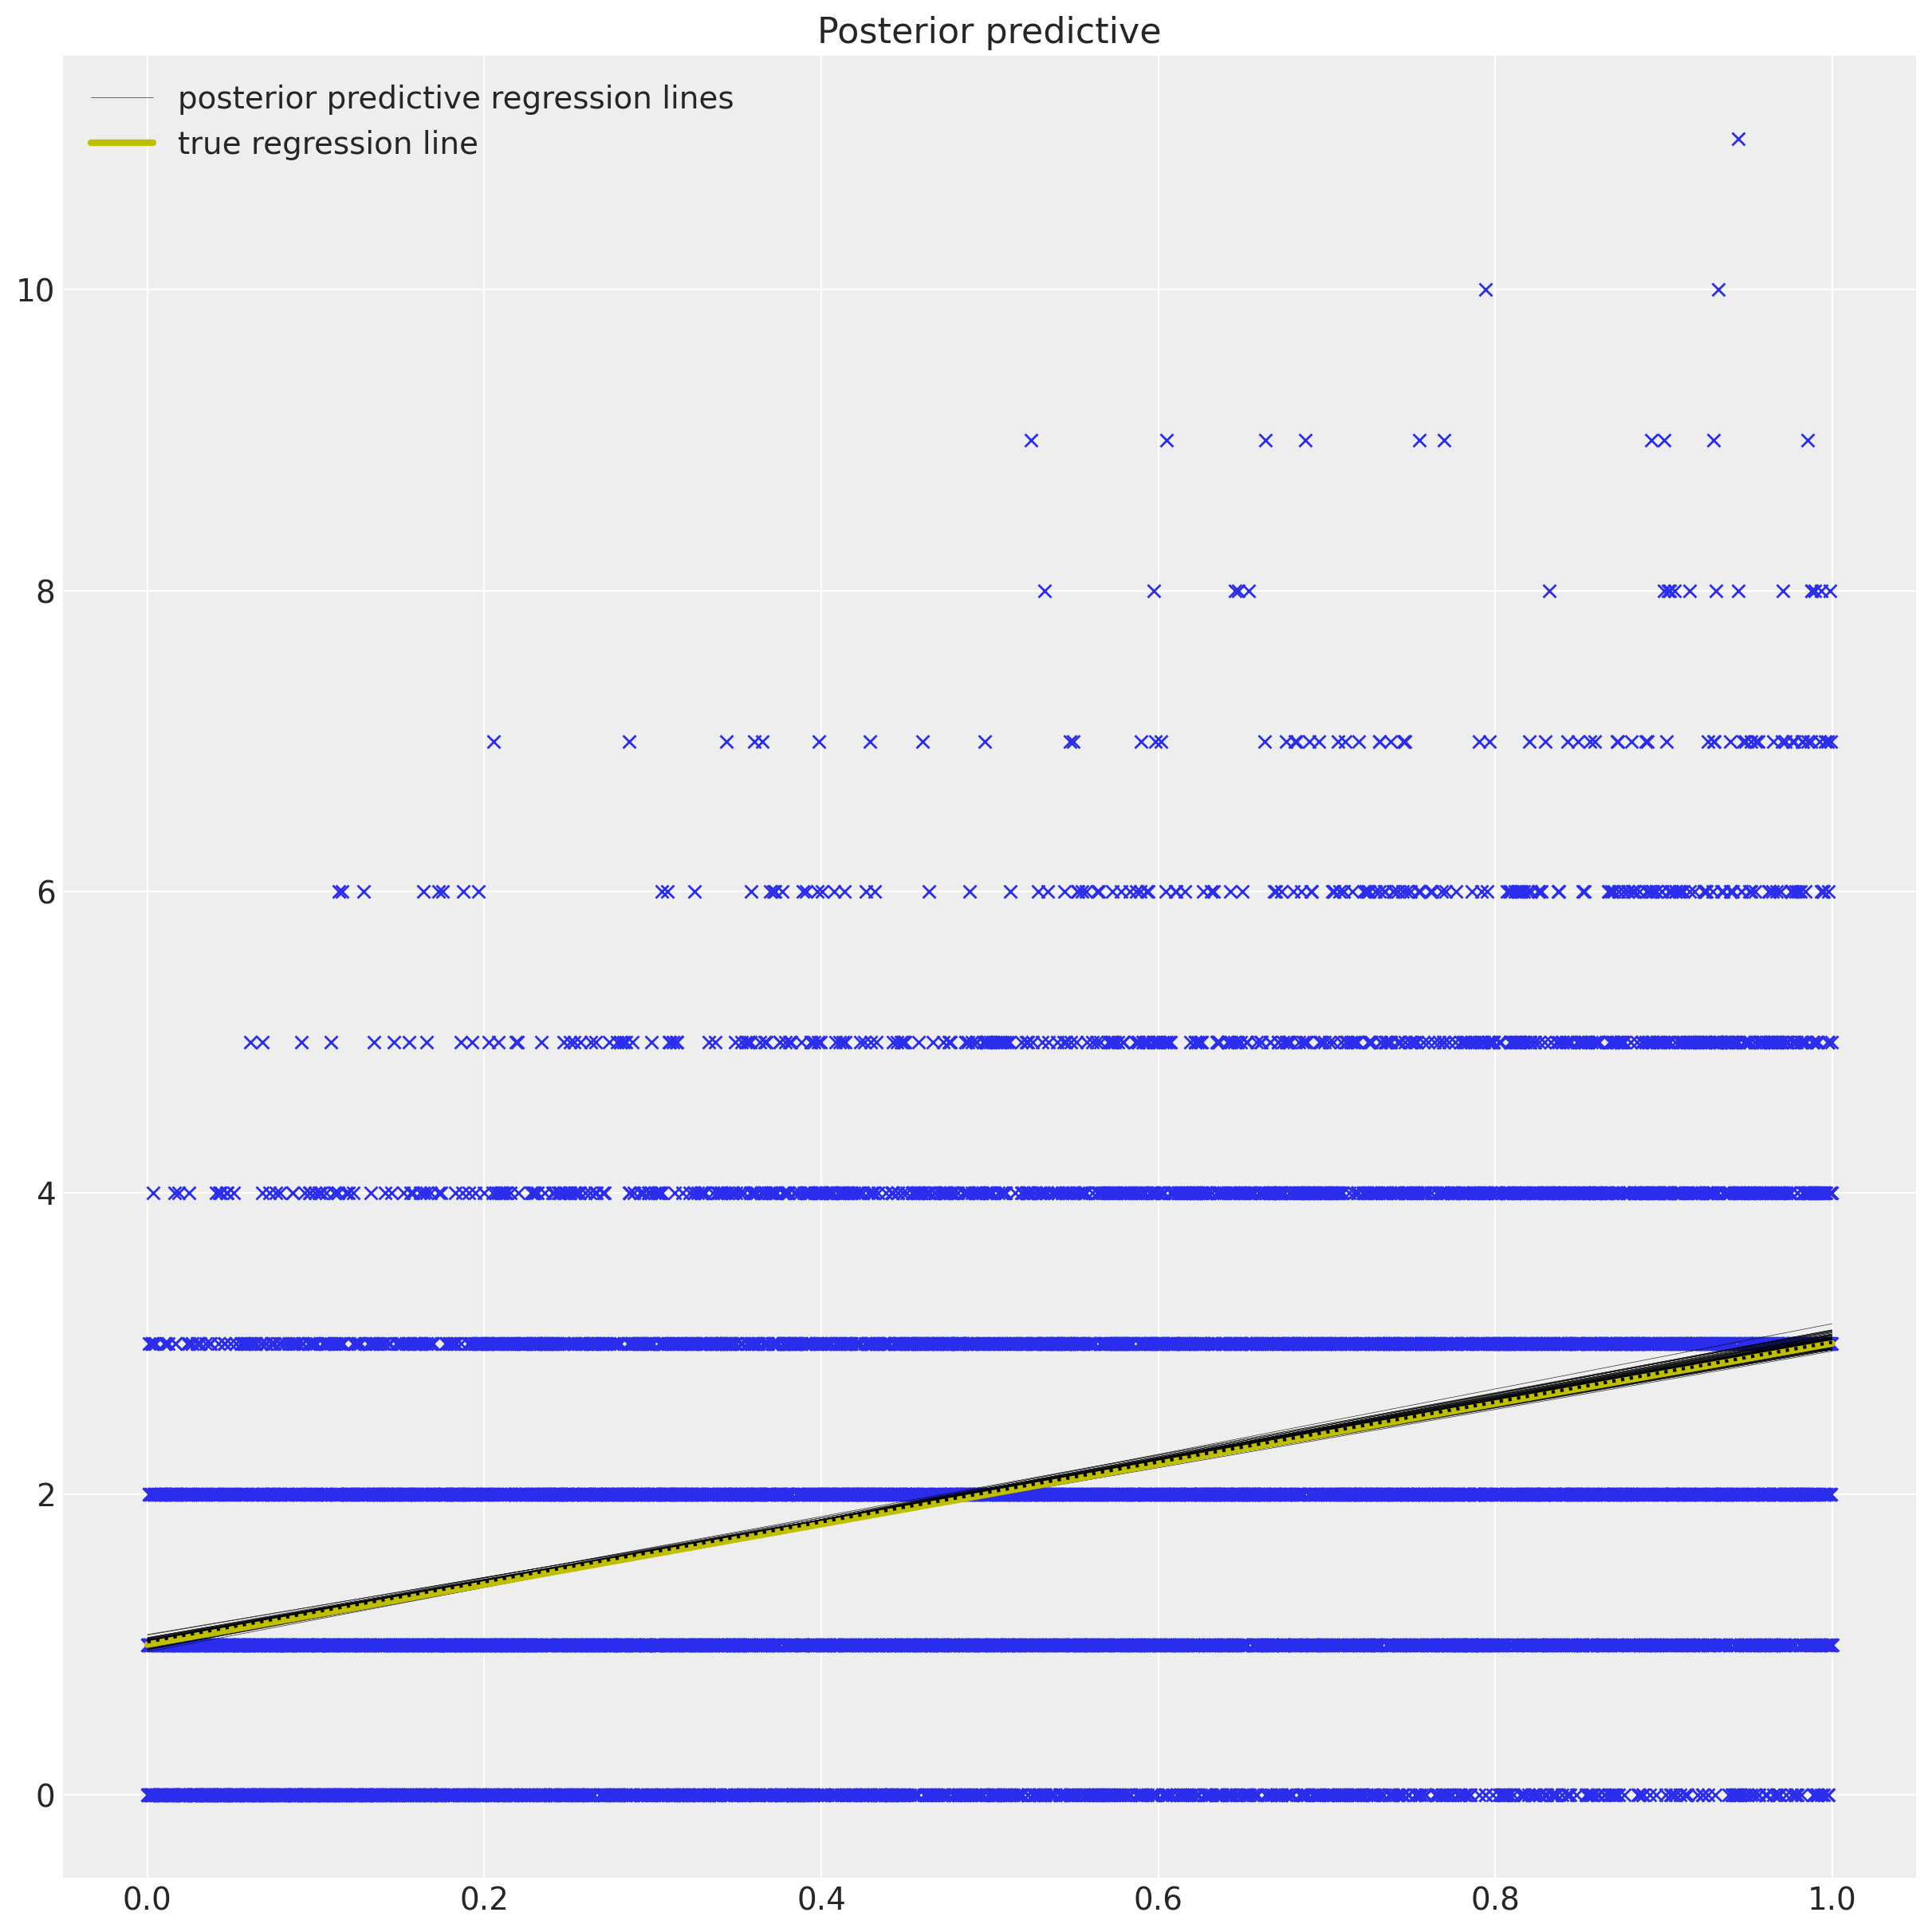

In [105]:
plt.figure(figsize=(12, 12))
plt.plot(x, y, 'x')
plot_posterior_predictive_glm(trace, samples=100, label="posterior predictive regression lines")
plt.plot(x, true_regression_line, 
         label='true regression line', lw=3., c='y')
plt.plot(x,m*x+b,'k:')
plt.legend();

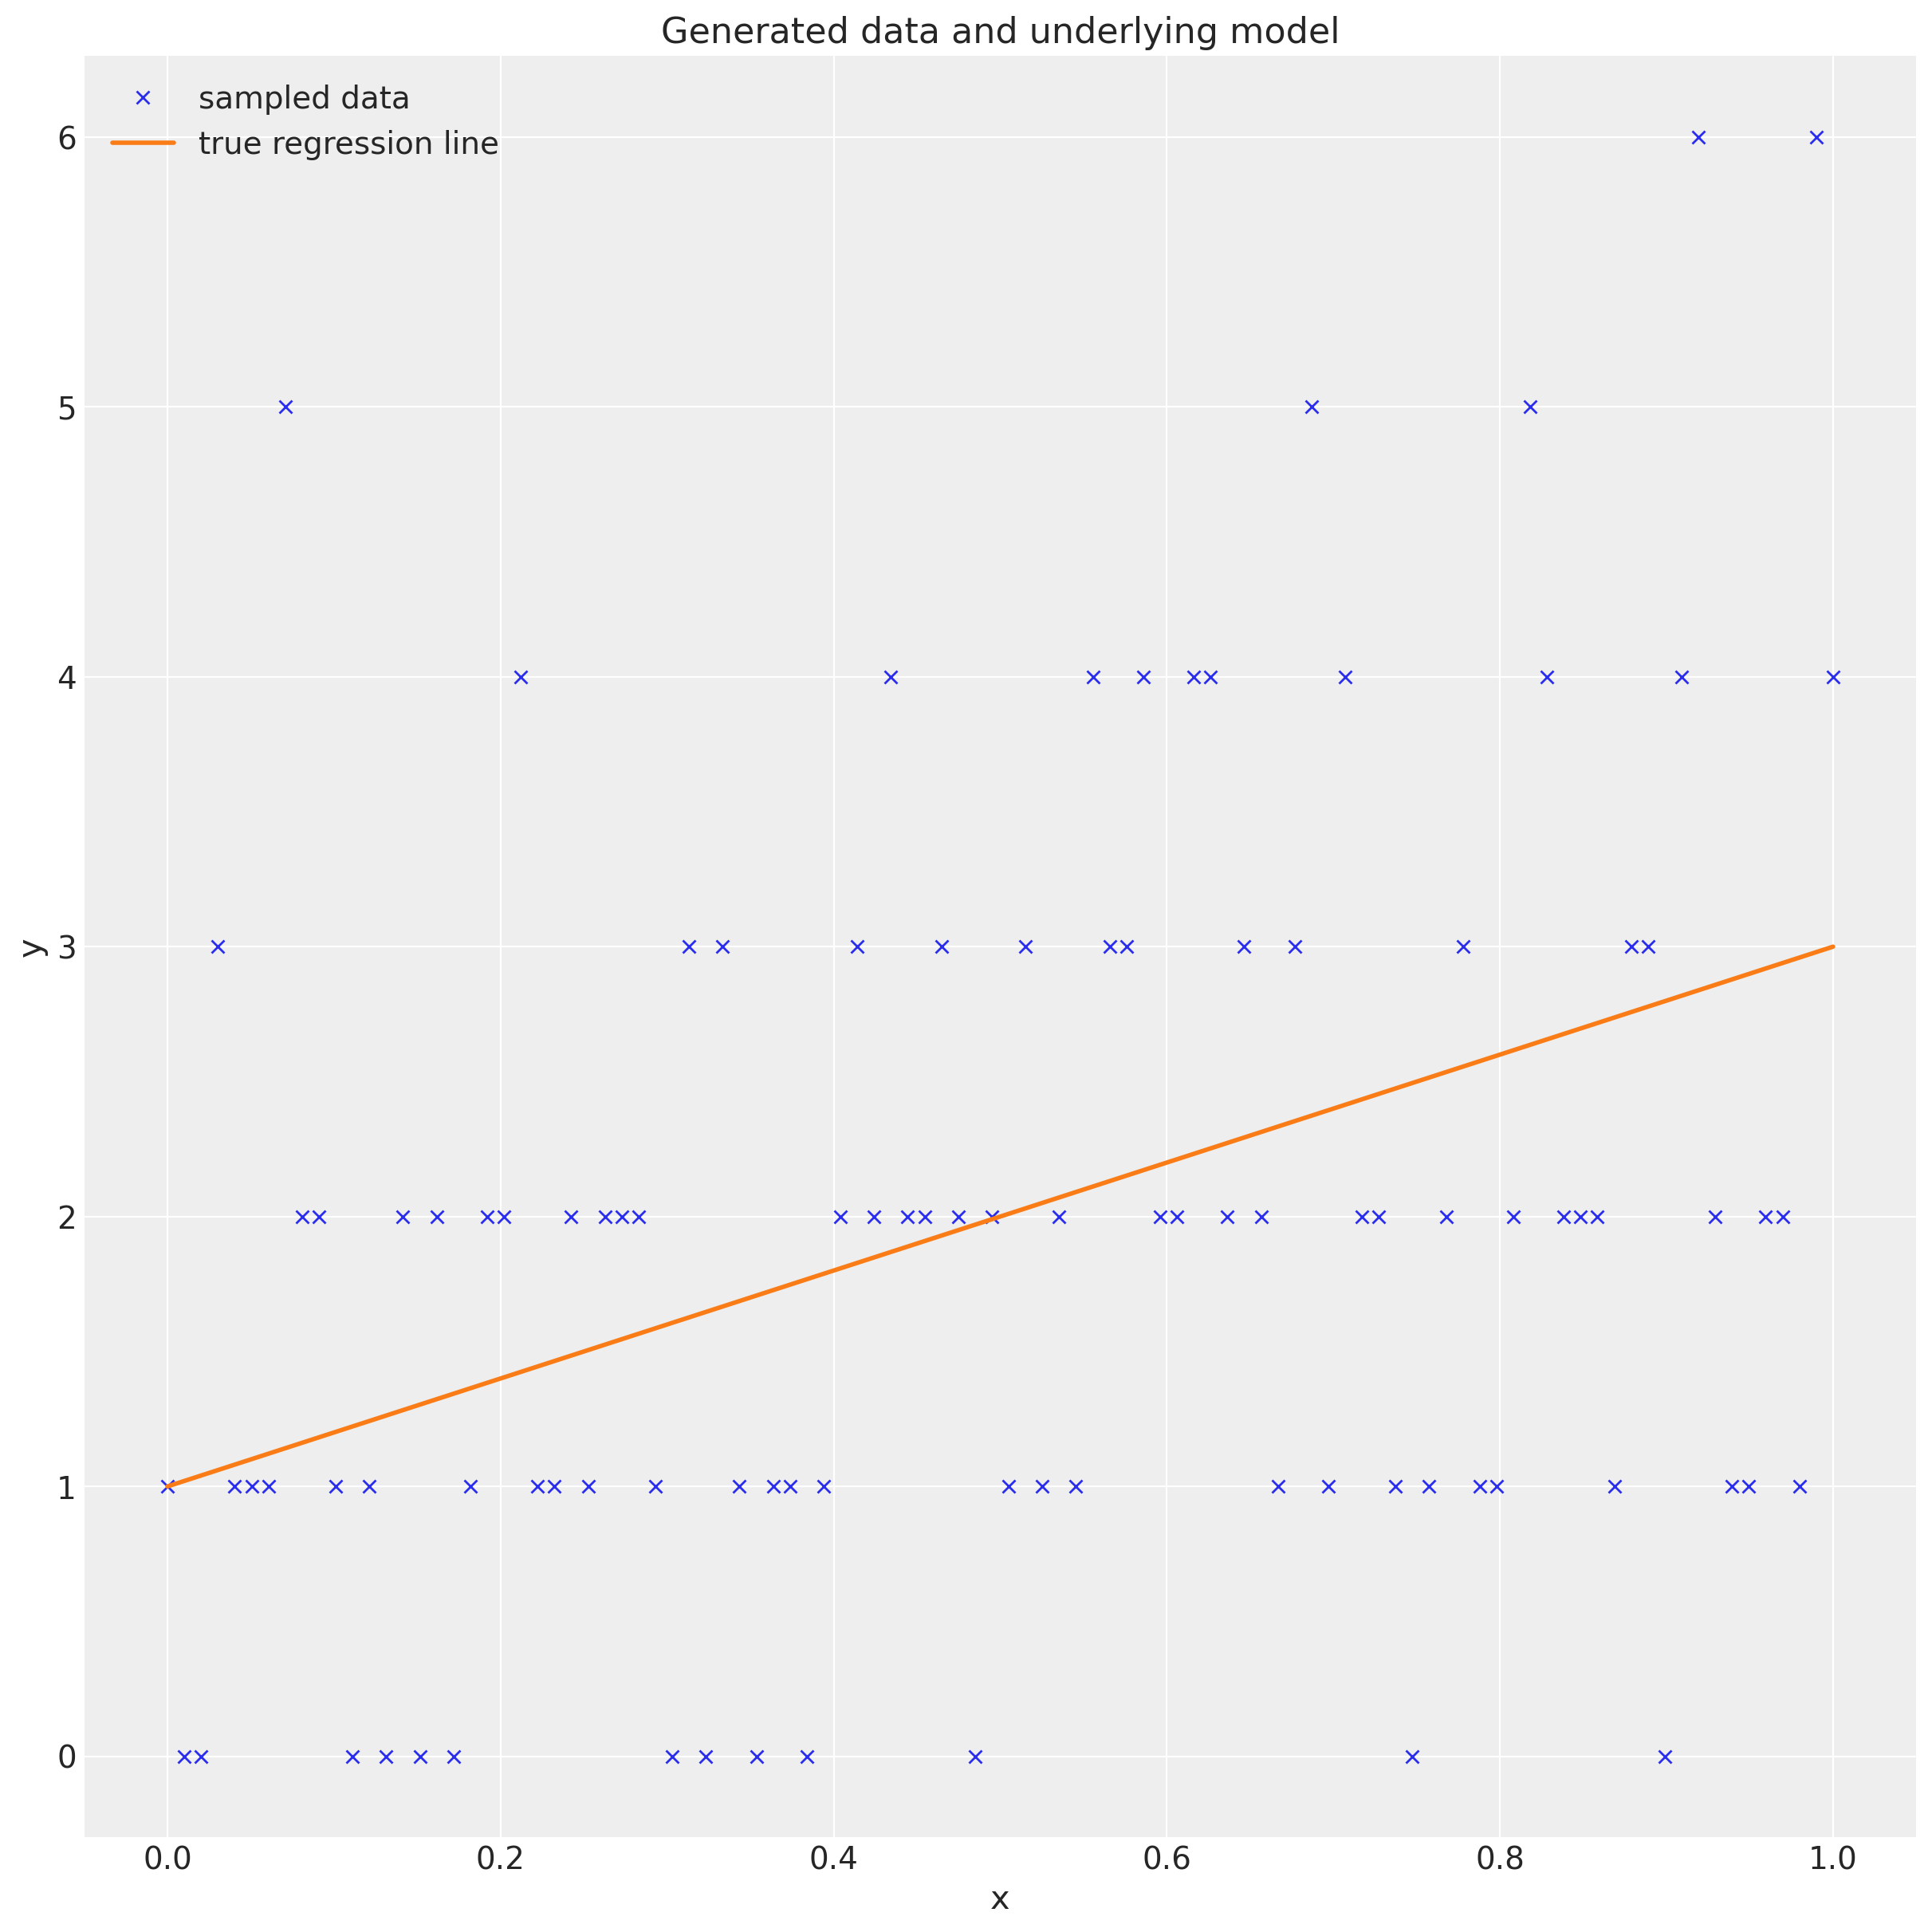

In [117]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111, xlabel='x', ylabel='y', title='Generated data and underlying model')
ax.plot(x, y, 'x', label='sampled data')
ax.plot(x, true_regression_line, label='true regression line', lw=2.)
plt.legend(loc=0);
#plt.ylim([-0.1,10.1])

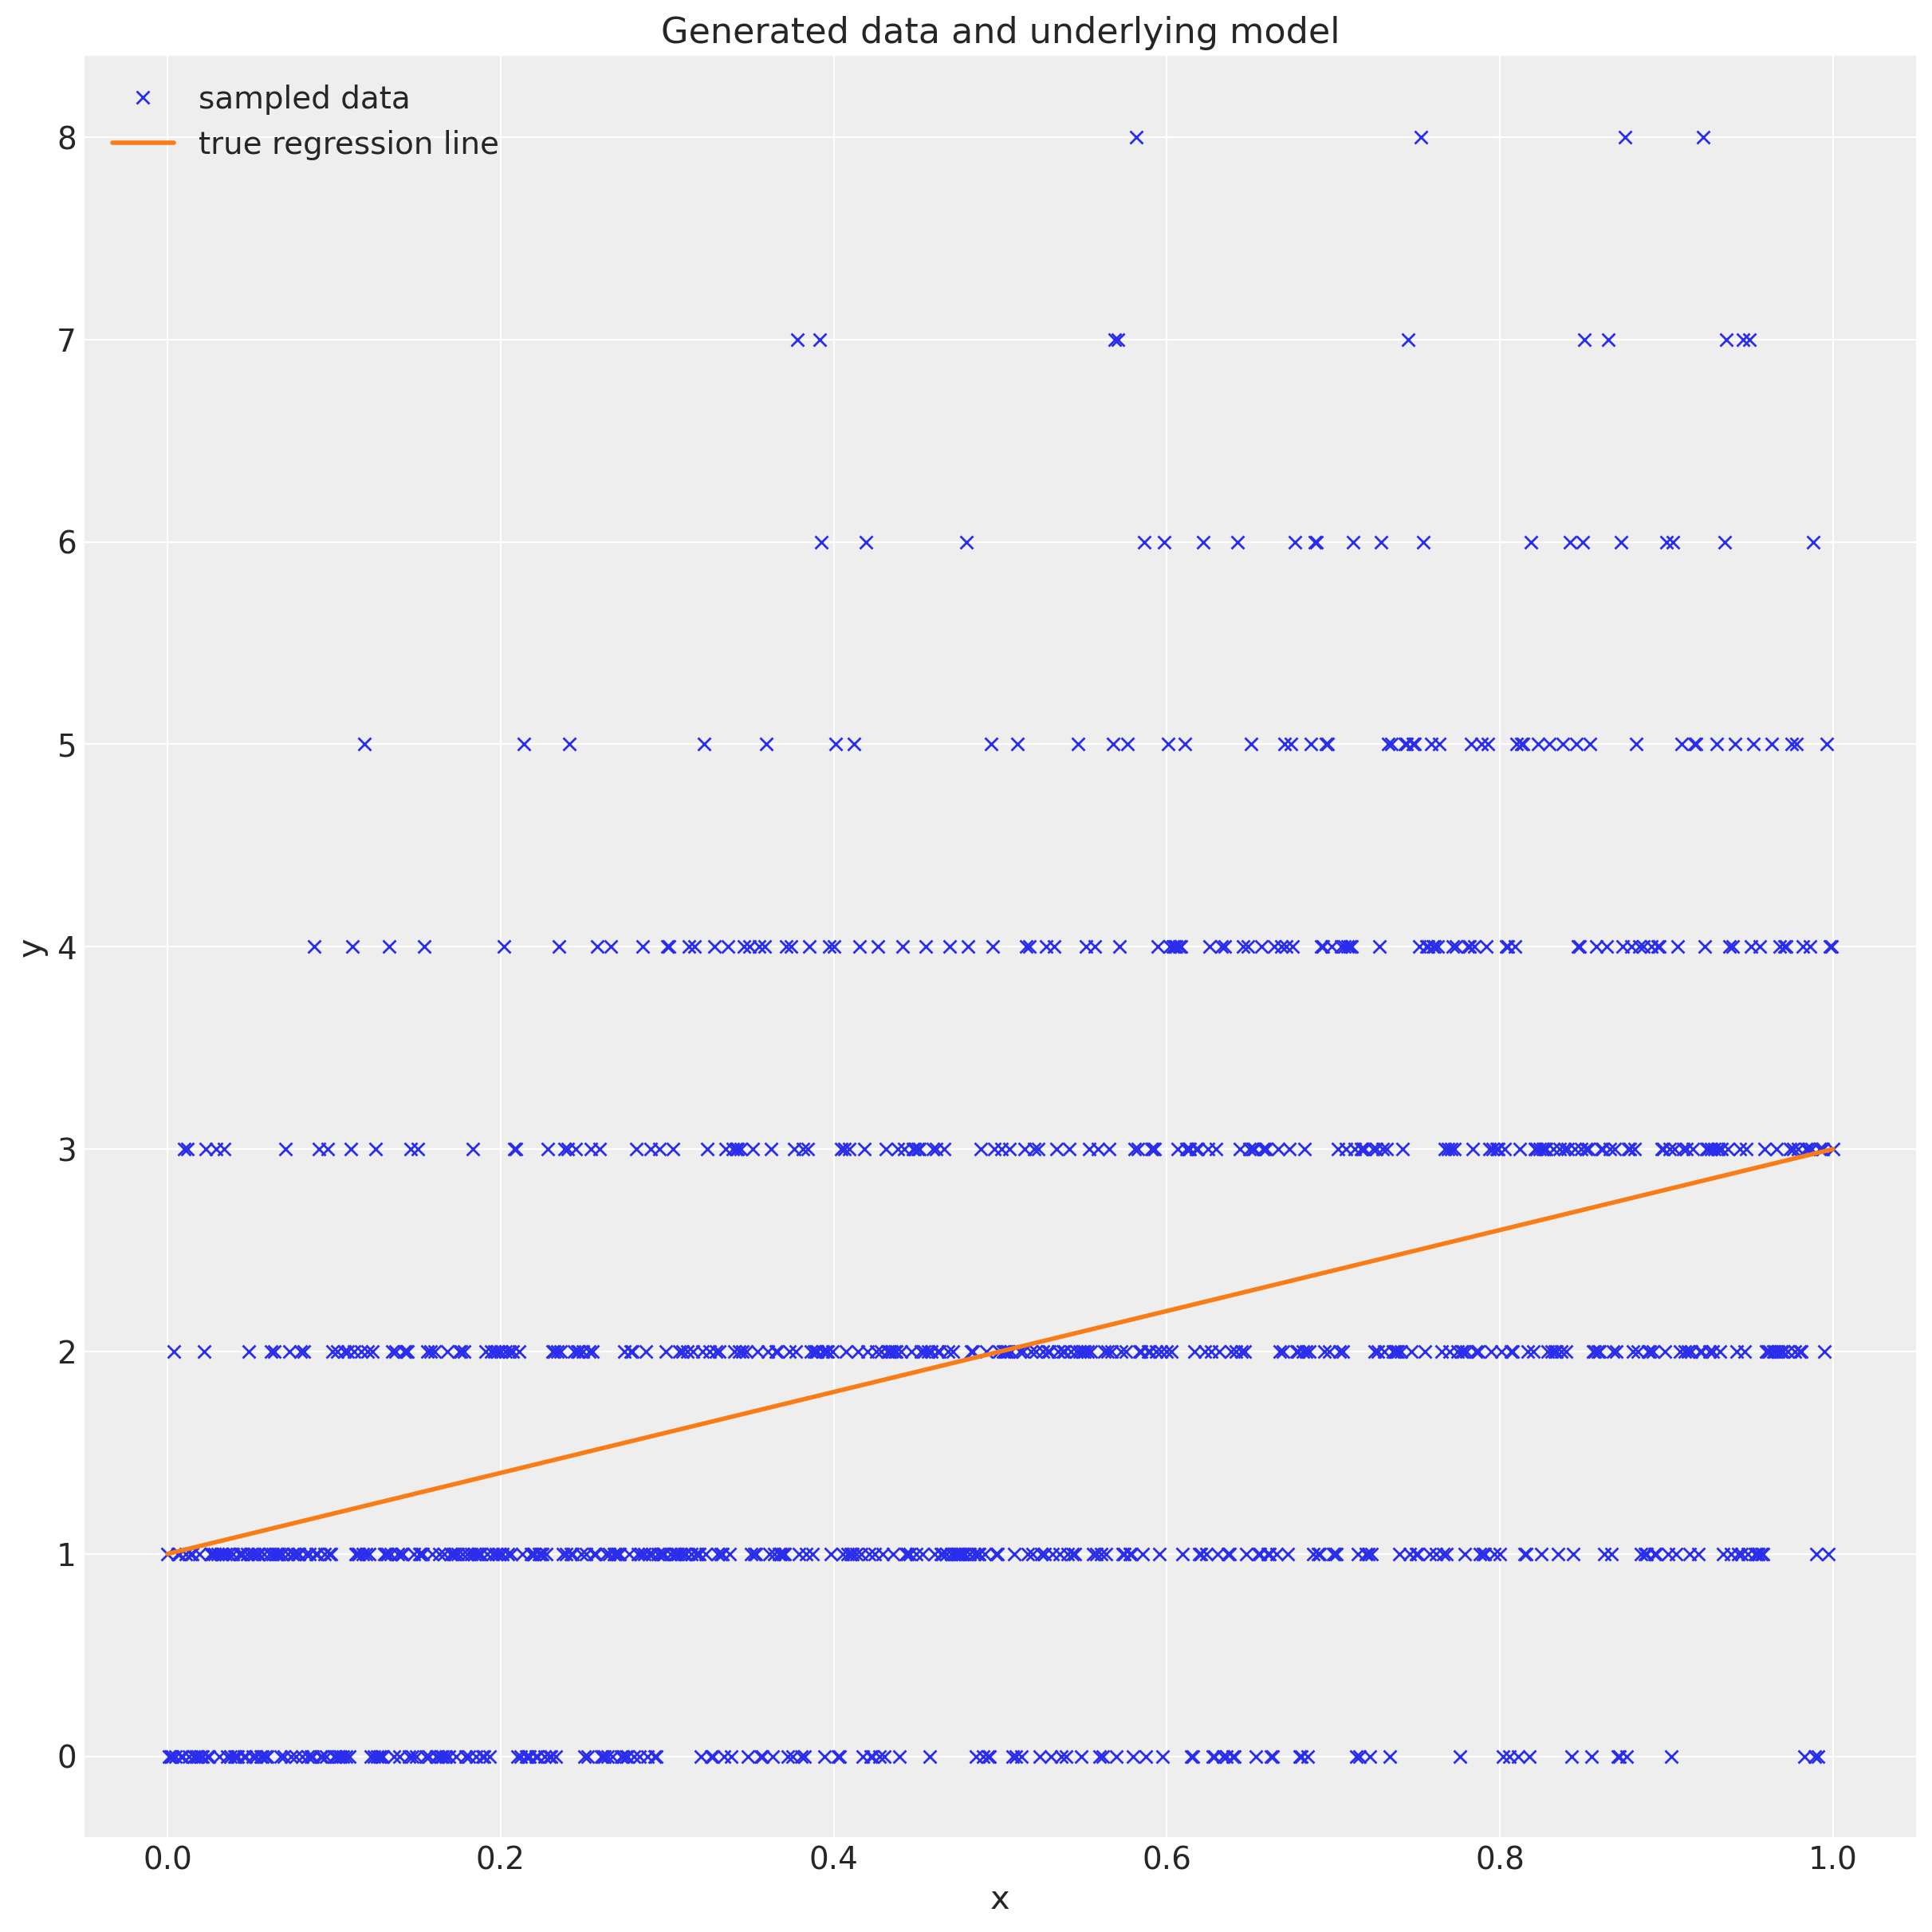

In [80]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111, xlabel='x', ylabel='y', title='Generated data and underlying model')
ax.plot(x, y, 'x', label='sampled data')
ax.plot(x, true_regression_line, label='true regression line', lw=2.)
plt.legend(loc=0);
#plt.ylim([-0.1,10.1])